In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import curve_fit
#from ydata_profiling import ProfileReport
import scipy.optimize
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import pacf, acf
from statsmodels.stats.diagnostic import normal_ad

import seaborn as sns



# Dane 

In [96]:
df_count = pd.read_csv('date_counts.csv')
print(df_count.columns)
count = df_count["Count"]
dates = df_count['Date']

n = len(count)
dates = pd.to_datetime(df_count['Date'])
n = len(count)
date0 = dates.iloc[0]
date_last = dates.iloc[-1]
timedelta = date_last - date0

print(n)
print("First day:", dates[0], "\nLast day:", dates[n-1], "\n Timedelta (this should be lenght of our data):", timedelta)
print("Maximum number of crimes:", max(count), "\nMinimum number of crimes:", min(count))

Index(['Date', 'Count'], dtype='object')
4017
First day: 2009-01-01 00:00:00 
Last day: 2019-12-31 00:00:00 
 Timedelta (this should be lenght of our data): 4016 days 00:00:00
Maximum number of crimes: 170 
Minimum number of crimes: 21


In [97]:
#profile = ProfileReport(df_count, title = "Number of crimes")
#profile.to_notebook_iframe()

C:\Users\User1\AppData\Local\Temp\ipykernel_5584\2348851542.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  xticks = pd.date_range(start=date0, end=date_last, freq='6M')


Text(0, 0.5, 'Liczba zgłoszonych przestępstw')

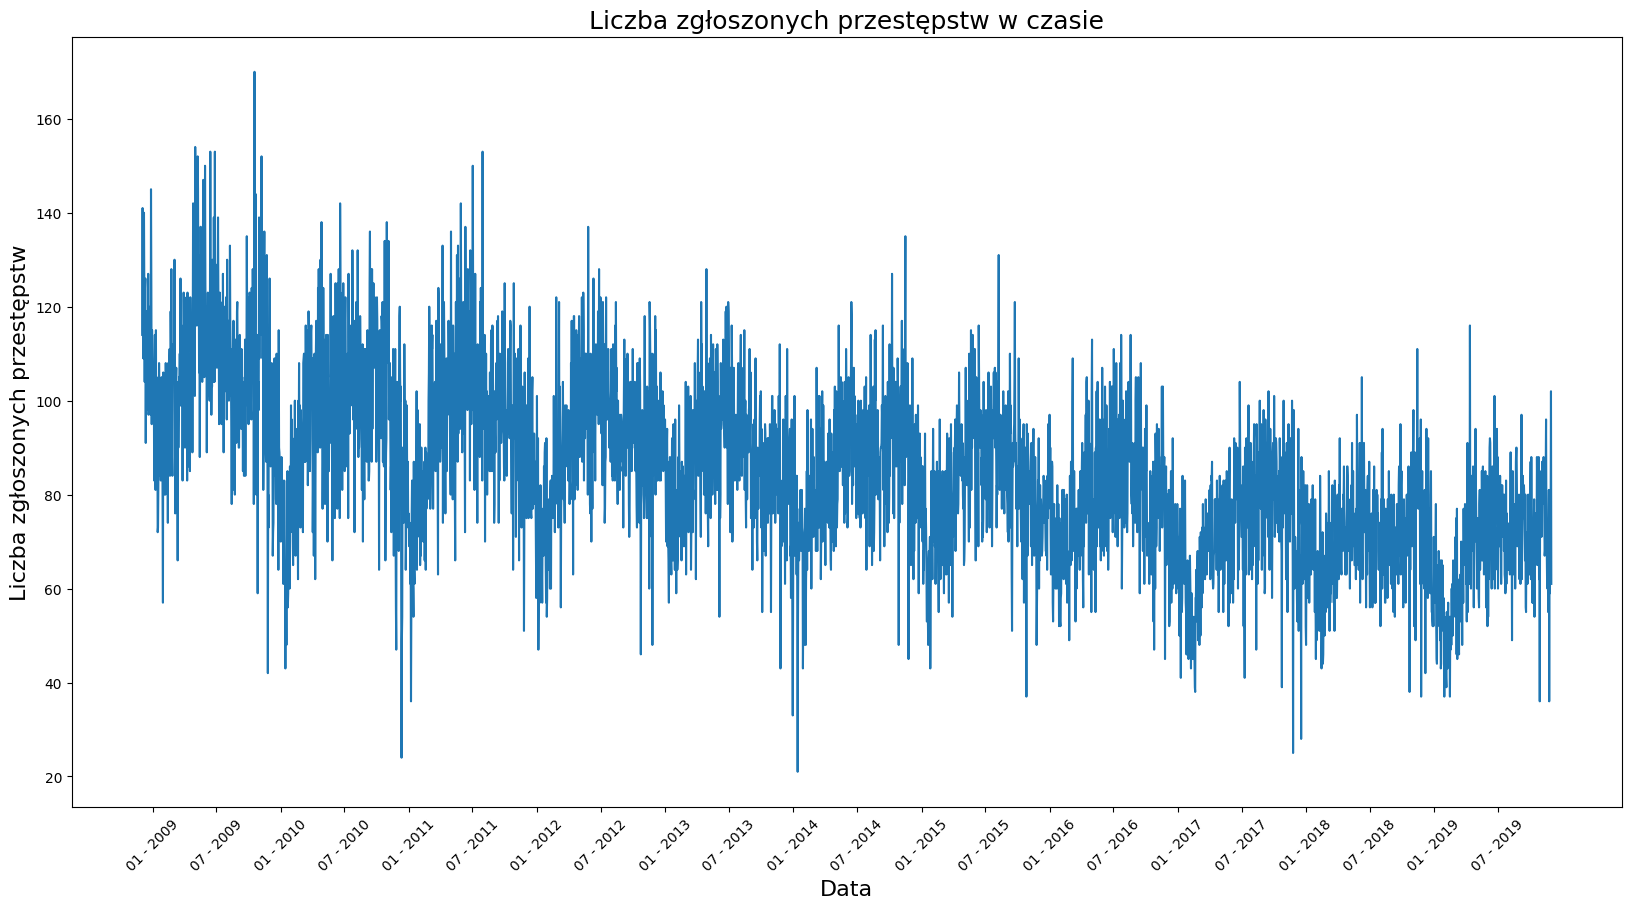

In [98]:
plt.figure(figsize=(20, 10))
dates = pd.to_datetime(df_count['Date'])
n = len(count)
date0 = dates.iloc[0]
date_last = dates.iloc[-1]
timedelta = date_last - date0


plt.plot(dates, count)
xticks = pd.date_range(start=date0, end=date_last, freq='6M')
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Liczba zgłoszonych przestępstw w czasie", fontsize=18)
plt.xlabel("Data", fontsize=16)
plt.ylabel("Liczba zgłoszonych przestępstw", fontsize=16)

Obcięcie danych

In [99]:
n_cut = int(0.99*len(count))
count_99 = count[:n_cut]

# Test ADF - wejsciowe dane

In [100]:
result = adfuller(count_99)
print("Hipoteza zerowa: dane są niestacjonarne")
print("Hipoteza alternatywna: dane są stacjonwarne")


print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Liczba opóźnień:", result[2])
print("Liczba obserwacji użytych do testu:", result[3])
print("Wartości krytyczne:")
for key, value in result[4].items():
    print(f"   {key}: {value:.3f}")

if result[1] < 0.05:
    print("Odrzucamy hipotezę zerową (dane są stacjonarne).")
else:
    print("Nie można odrzucić hipotezy zerowej (dane są niestacjonarne).")

Hipoteza zerowa: dane są niestacjonarne
Hipoteza alternatywna: dane są stacjonwarne
ADF Statistic: -3.607846555344276
p-value: 0.0056127782078653
Liczba opóźnień: 29
Liczba obserwacji użytych do testu: 3946
Wartości krytyczne:
   1%: -3.432
   5%: -2.862
   10%: -2.567
Odrzucamy hipotezę zerową (dane są stacjonarne).


# Dekompozycja

In [101]:
def autocov_emp(X, h):
    n = len(X)
    h = abs(h)
    return 1/n*sum([(X[i] - np.mean(X))*(X[i + h] - np.mean(X)) for i in range(n - h)])

def autocorr_emp(X, h):
    return autocov_emp(X,h)/autocov_emp(X, 0)

def prosta_regresji(X, Y):
    b_1 = sum((X - np.mean(X))*(Y - np.mean(Y))) / sum((X- np.mean(X))**2)
    b_0 = np.mean(Y) - b_1*np.mean(X)
    return b_0, b_1

def fun(x, c,d, e):
    return c*np.sin(d*x + e)


def fun2(x, c, d, e):
    return c*np.sin(d*x + e)


Transformacja Boxa-Coxa

count_transformed: [26.022 29.725 26.165 ... 19.955 19.091 22.096] 
lmbda_for_count: 0.5900136531716227
8.520759142574262 33.39107515071527


C:\Users\User1\AppData\Local\Temp\ipykernel_5584\1272806316.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  xticks = pd.date_range(start=date0, end=date_last, freq='6M')
C:\Users\User1\AppData\Local\Temp\ipykernel_5584\1272806316.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  xticks = pd.date_range(start=date0, end=date_last, freq='6M')


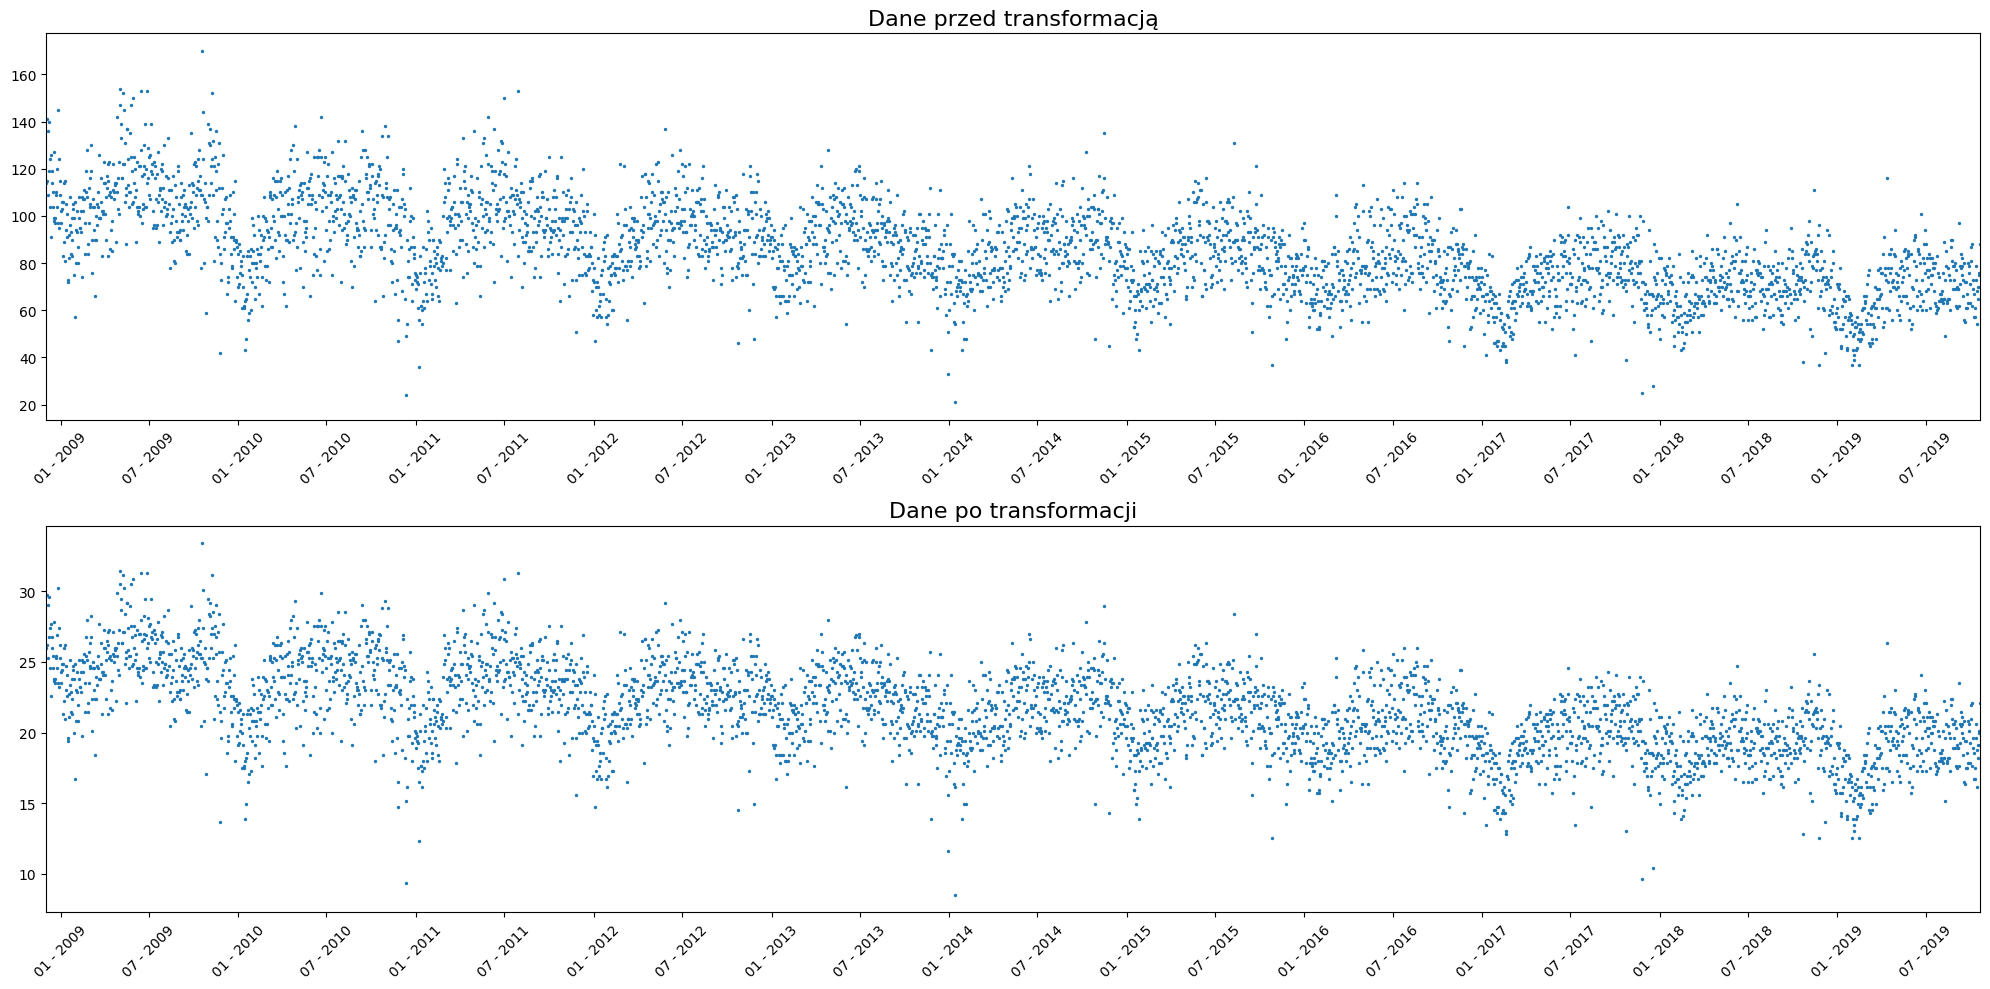

In [102]:
count_transformed, lmbda_for_count = stats.boxcox(count_99)
print(f'count_transformed: {count_transformed.round(3)} \nlmbda_for_count: {lmbda_for_count}')
print(min(count_transformed), max(count_transformed))
n = len(count_transformed)
X = np.arange(0, n, 1)

dates = pd.to_datetime(df_count['Date'][:n])
date0 = dates.iloc[0]
date_last = dates.iloc[-1]
timedelta = date_last - date0

plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.scatter(dates, count_99, s = 2)
xticks = pd.date_range(start=date0, end=date_last, freq='6M')
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane przed transformacją", fontsize = 16)
plt.xlim([dates.min(), dates.max()])

plt.subplot(2, 1, 2)
plt.scatter(dates, count_transformed, s = 2)
xticks = pd.date_range(start=date0, end=date_last, freq='6M')
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane po transformacji", fontsize = 16)
plt.xlim([dates.min(), dates.max()])
plt.tight_layout()

24.685453234491625 -0.0015754224789080553
2.6392894587888254
Okres: 387.7763775385555 2.0000000000000004


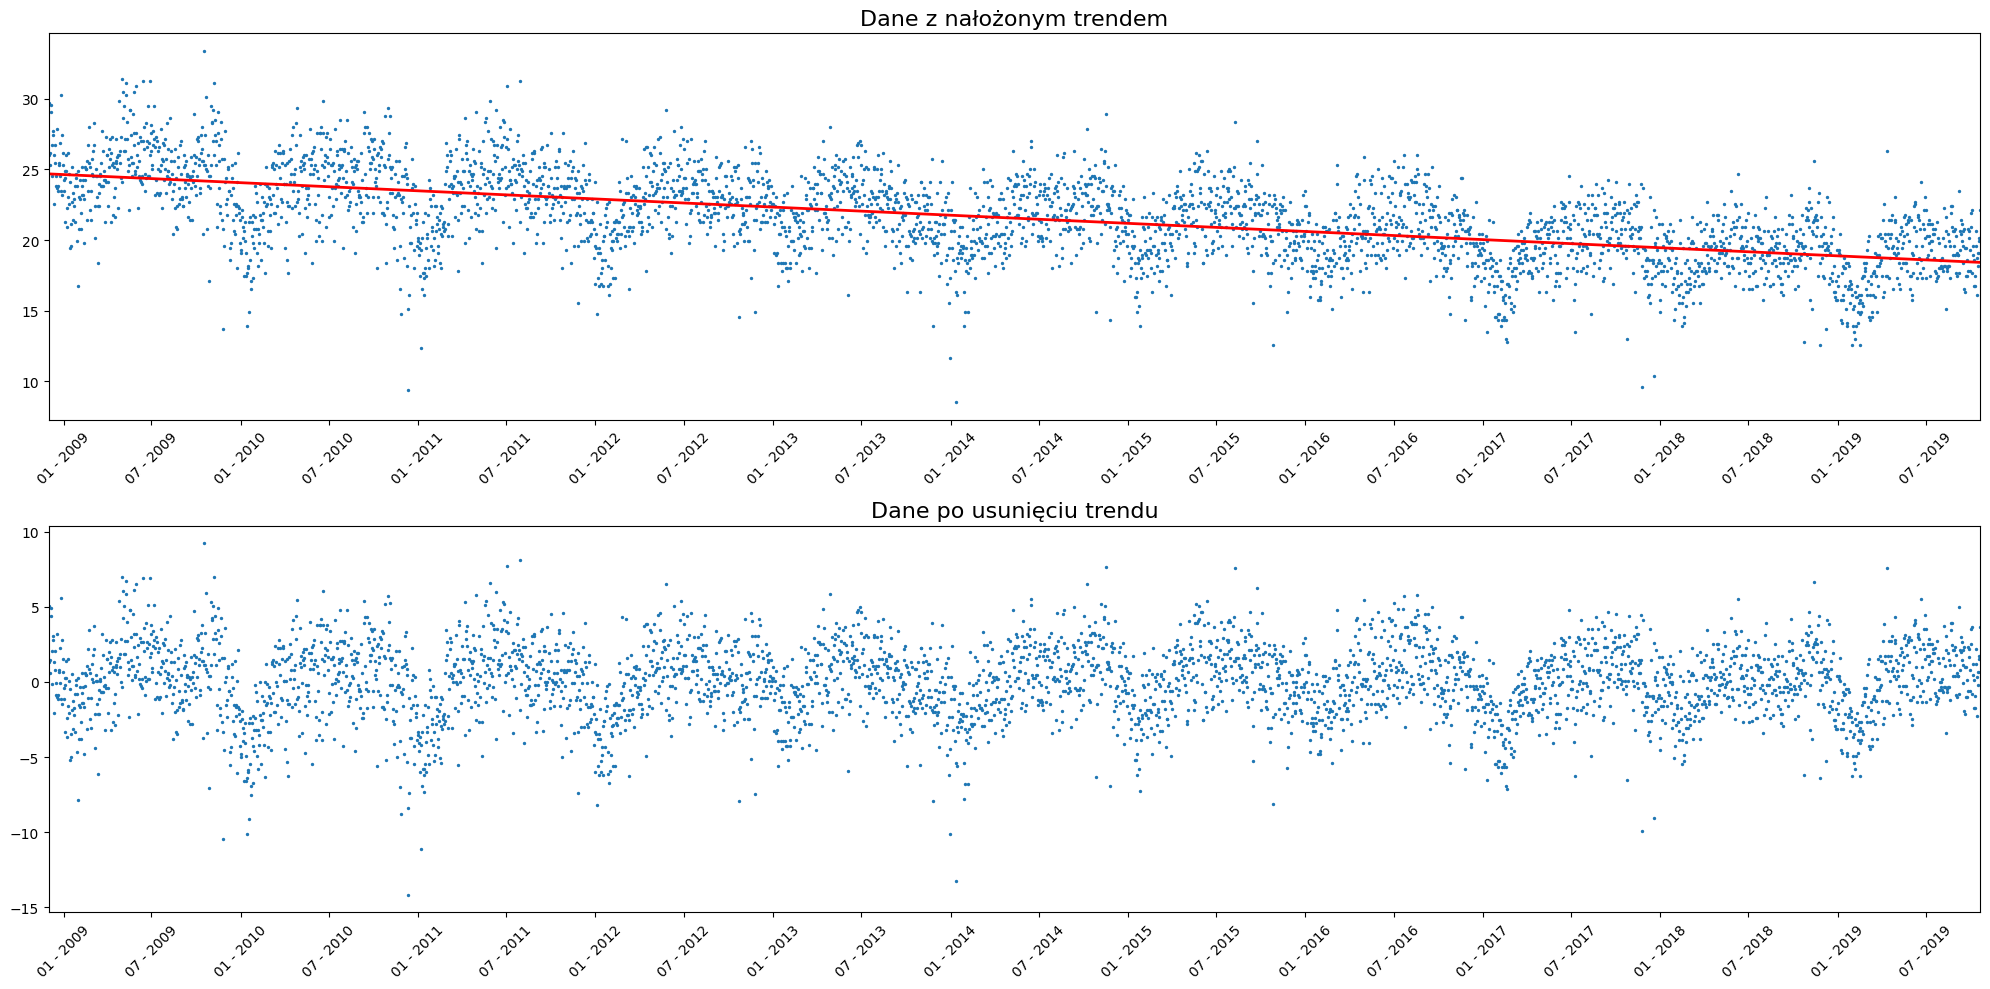

In [103]:
n = len(count_transformed)
X = np.arange(0, n, 1)
b_0, b_1 = prosta_regresji(X, count_transformed)
prosta = b_0 + b_1*X
count_bez_trendu = count_transformed - prosta
print(b_0, b_1)

Q = np.quantile(count_bez_trendu[:1500], 0.85)
print(Q)
p0 = [Q, 2 * np.pi / 365, 0]


params, pcov = scipy.optimize.curve_fit(f = fun, xdata = X, ydata = count_bez_trendu, p0 = p0, bounds = ((2, 2 * np.pi / 500, 0), (30, 2 * np.pi / 300, 2 * np.pi)))
sezonowosc= np.array([fun(x, params[0], params[1], params[2]) for x in X])

count_bez_sezonu = count_bez_trendu-sezonowosc



print("Okres:",2*np.pi/params[1], params[0])
plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.plot(dates, prosta, c = 'r', linewidth = 2)
plt.scatter(dates, count_transformed, s = 2)
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane z nałożonym trendem", fontsize = 16)
plt.xlim([dates.min(), dates.max()])
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.scatter(dates, count_bez_trendu, s = 2)
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane po usunięciu trendu", fontsize = 16)
plt.xlim([dates.min(), dates.max()])
plt.tight_layout()

plt.show()


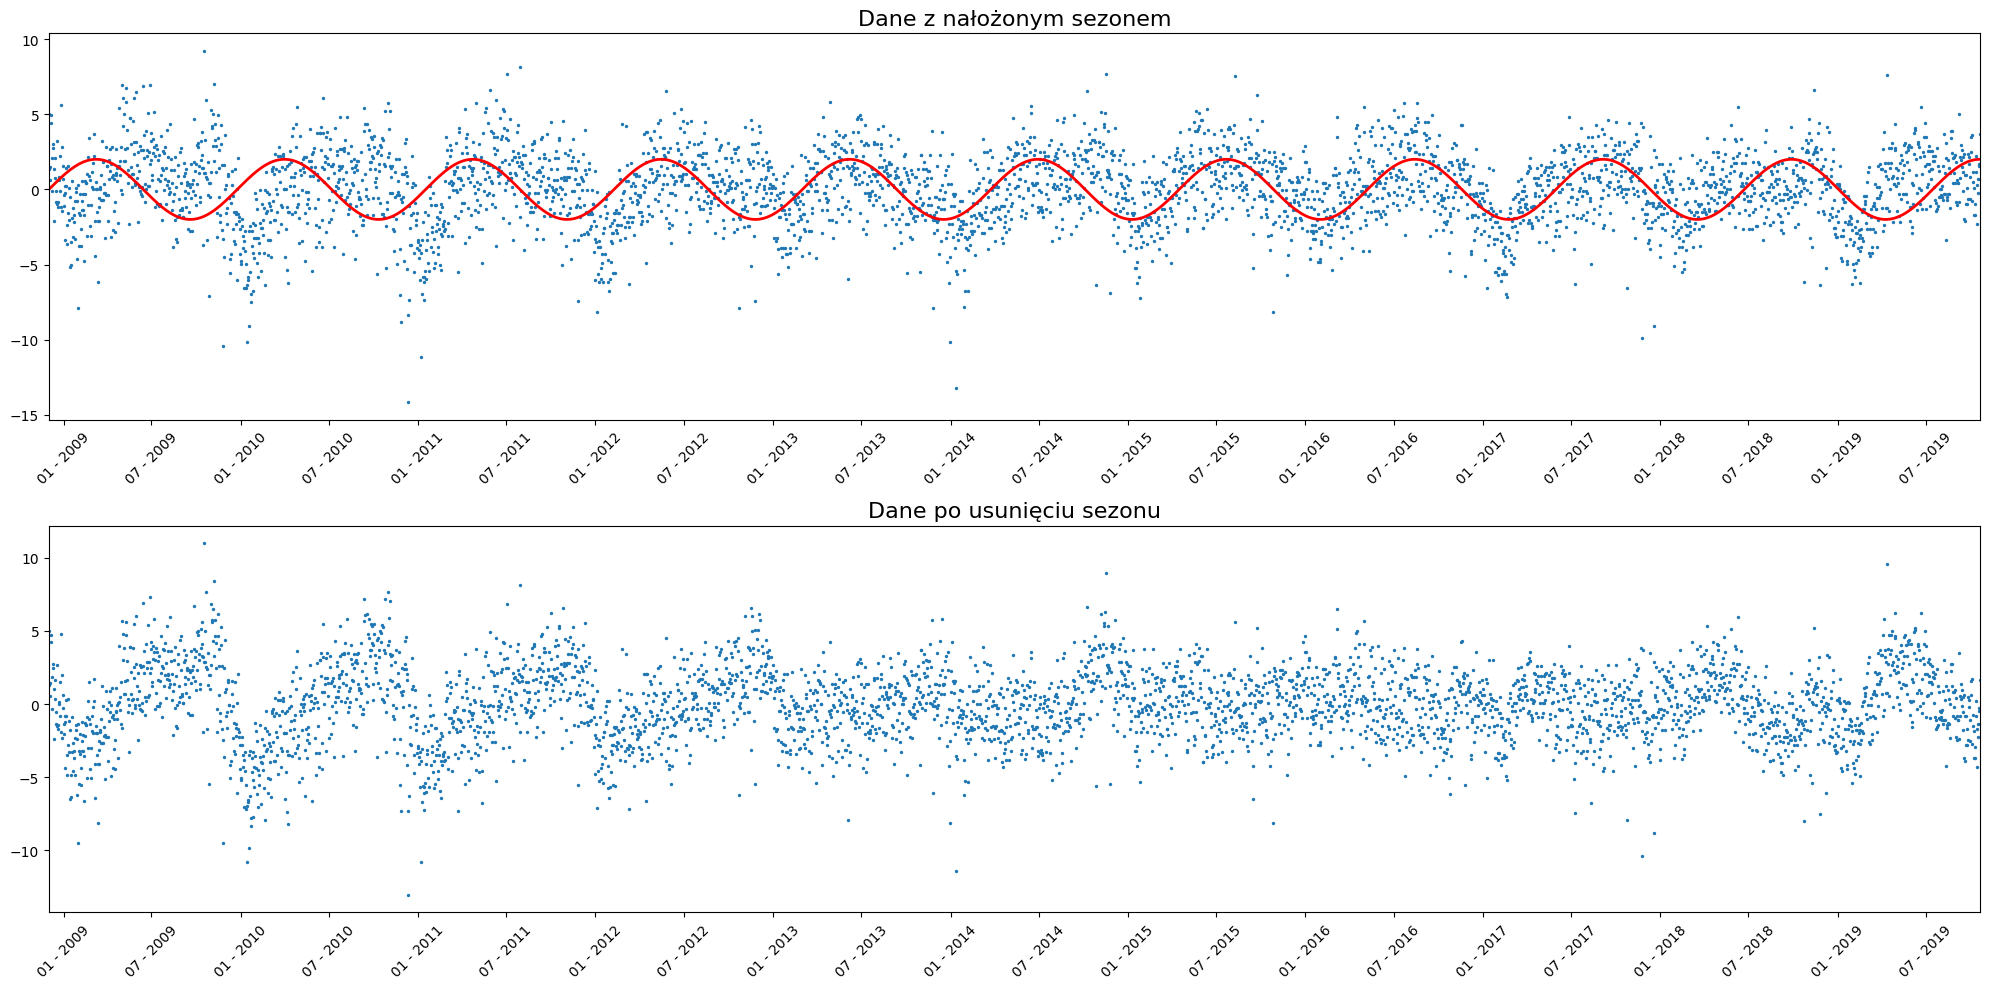

In [104]:
plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.plot(dates, sezonowosc, c = 'r', linewidth = 2)
plt.scatter(dates, count_bez_trendu, s = 2)
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane z nałożonym sezonem", fontsize = 16)
plt.xlim([dates.min(), dates.max()])
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.scatter(dates, count_bez_sezonu, s = 2)
plt.xticks(xticks, labels=[d.strftime('%m - %Y') for d in xticks], rotation=45)
plt.title("Dane po usunięciu sezonu", fontsize = 16)
plt.xlim([dates.min(), dates.max()])
plt.tight_layout()

plt.show()


Test ADF - dane po dekompozycji

In [105]:
result = adfuller(count_bez_sezonu)
print("Hipoteza zerowa: dane są niestacjonarne")
print("Hipoteza alternatywna: dane są stacjonwarne")


print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Liczba opóźnień:", result[2])
print("Liczba obserwacji użytych do testu:", result[3])
print("Wartości krytyczne:")
for key, value in result[4].items():
    print(f"   {key}: {value:.3f}")

if result[1] < 0.05:
    print("Odrzucamy hipotezę zerową (dane są stacjonarne).")
else:
    print("Nie można odrzucić hipotezy zerowej (dane są niestacjonarne).")

Hipoteza zerowa: dane są niestacjonarne
Hipoteza alternatywna: dane są stacjonwarne
ADF Statistic: -5.301435719305863
p-value: 5.438281219911676e-06
Liczba opóźnień: 29
Liczba obserwacji użytych do testu: 3946
Wartości krytyczne:
   1%: -3.432
   5%: -2.862
   10%: -2.567
Odrzucamy hipotezę zerową (dane są stacjonarne).


# ACF I PACF

In [106]:
def autocov(X, h):
    n = len(X)
    result = 0
    X_mean = np.mean(X)
    h = np.abs(h)
    for i in range(n - h):
        result += (X[i] - X_mean)*(X[i +h] - X_mean)
    
    result /= n
    return result    

def autocorr(X, h):
    return (autocov(X, h)/ autocov(X,0))  

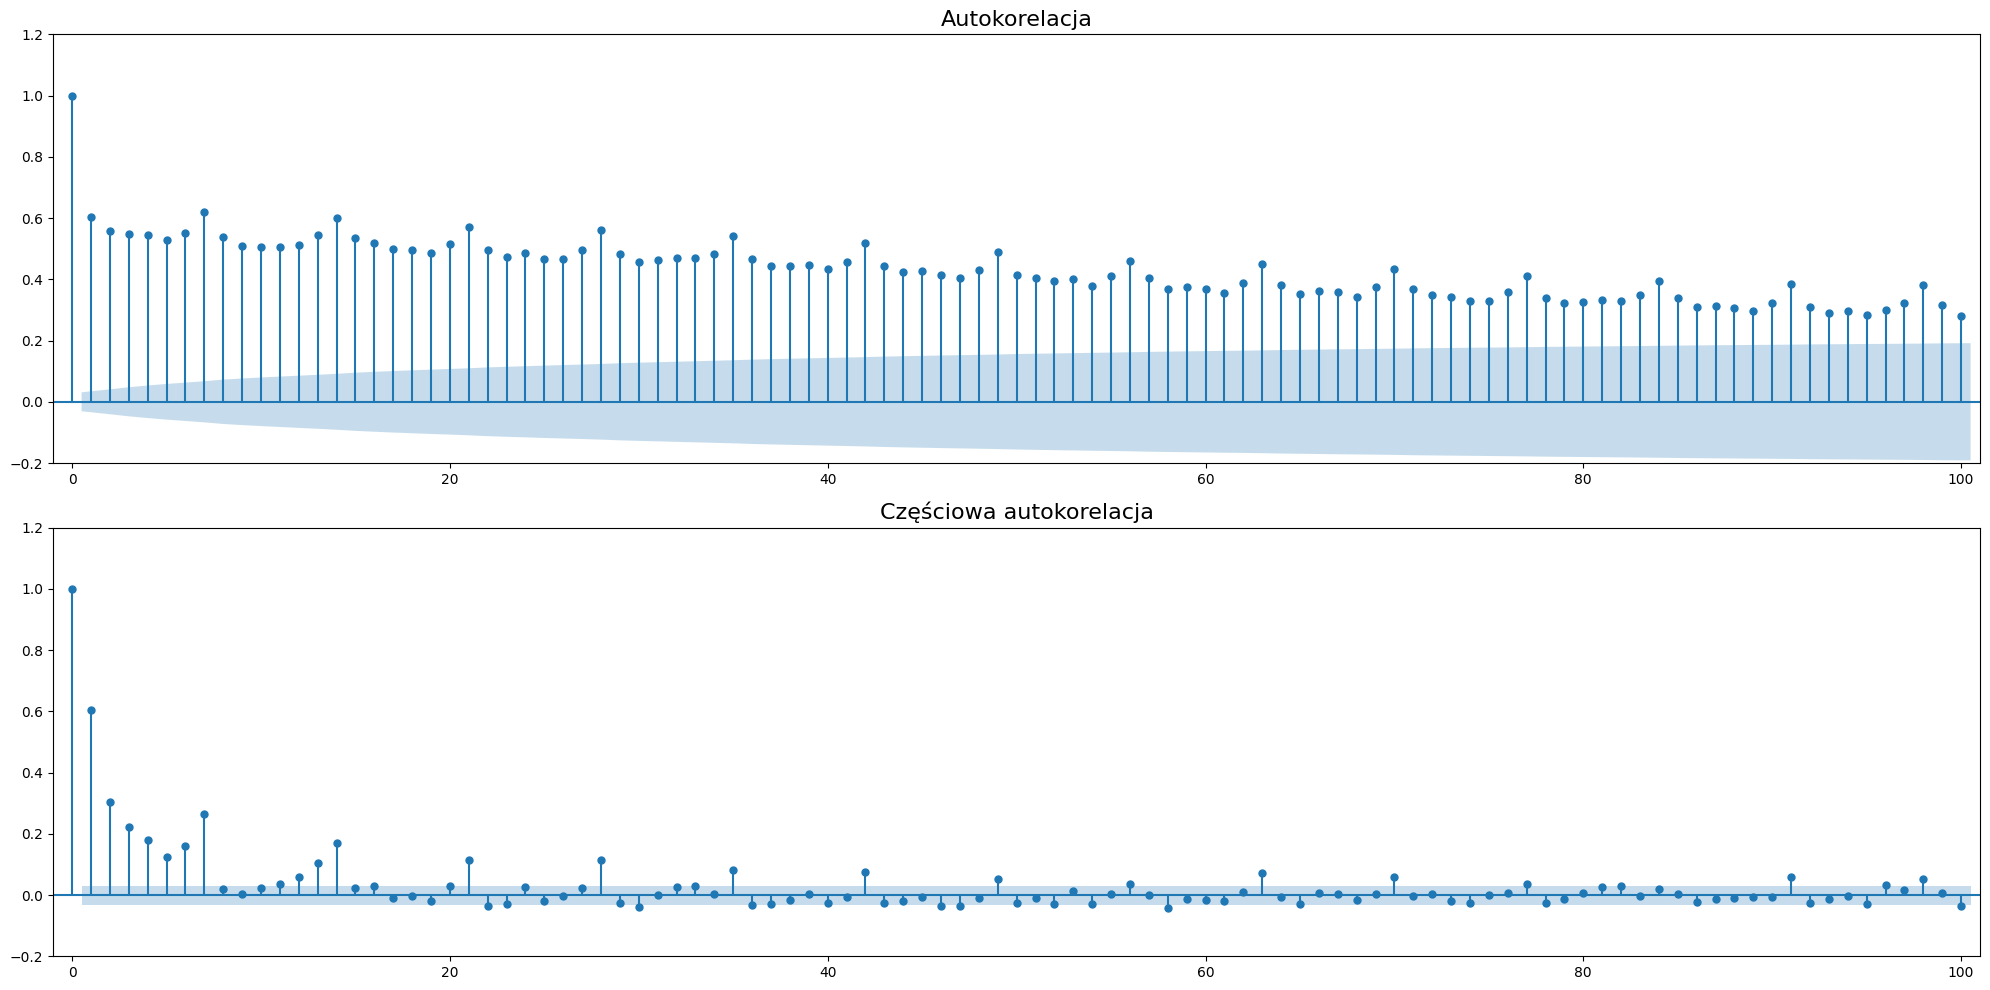

In [107]:
h = 100

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plot_acf(count, lags=min(h, len(count) - 1), adjusted=True, ax=plt.gca())
plt.title("Autokorelacja", fontsize=16
          )
plt.xlim([-1, 101])
plt.ylim([-0.2, 1.2])
# Partial Autocorrelation Function
plt.subplot(2, 1, 2)
plot_pacf(count, lags=min(h, len(count) - 1), method='ywm', ax=plt.gca())
plt.title("Częściowa autokorelacja", fontsize=16)
plt.xlim([-1, 101])
plt.ylim([-0.2, 1.2])

plt.tight_layout()
plt.show()

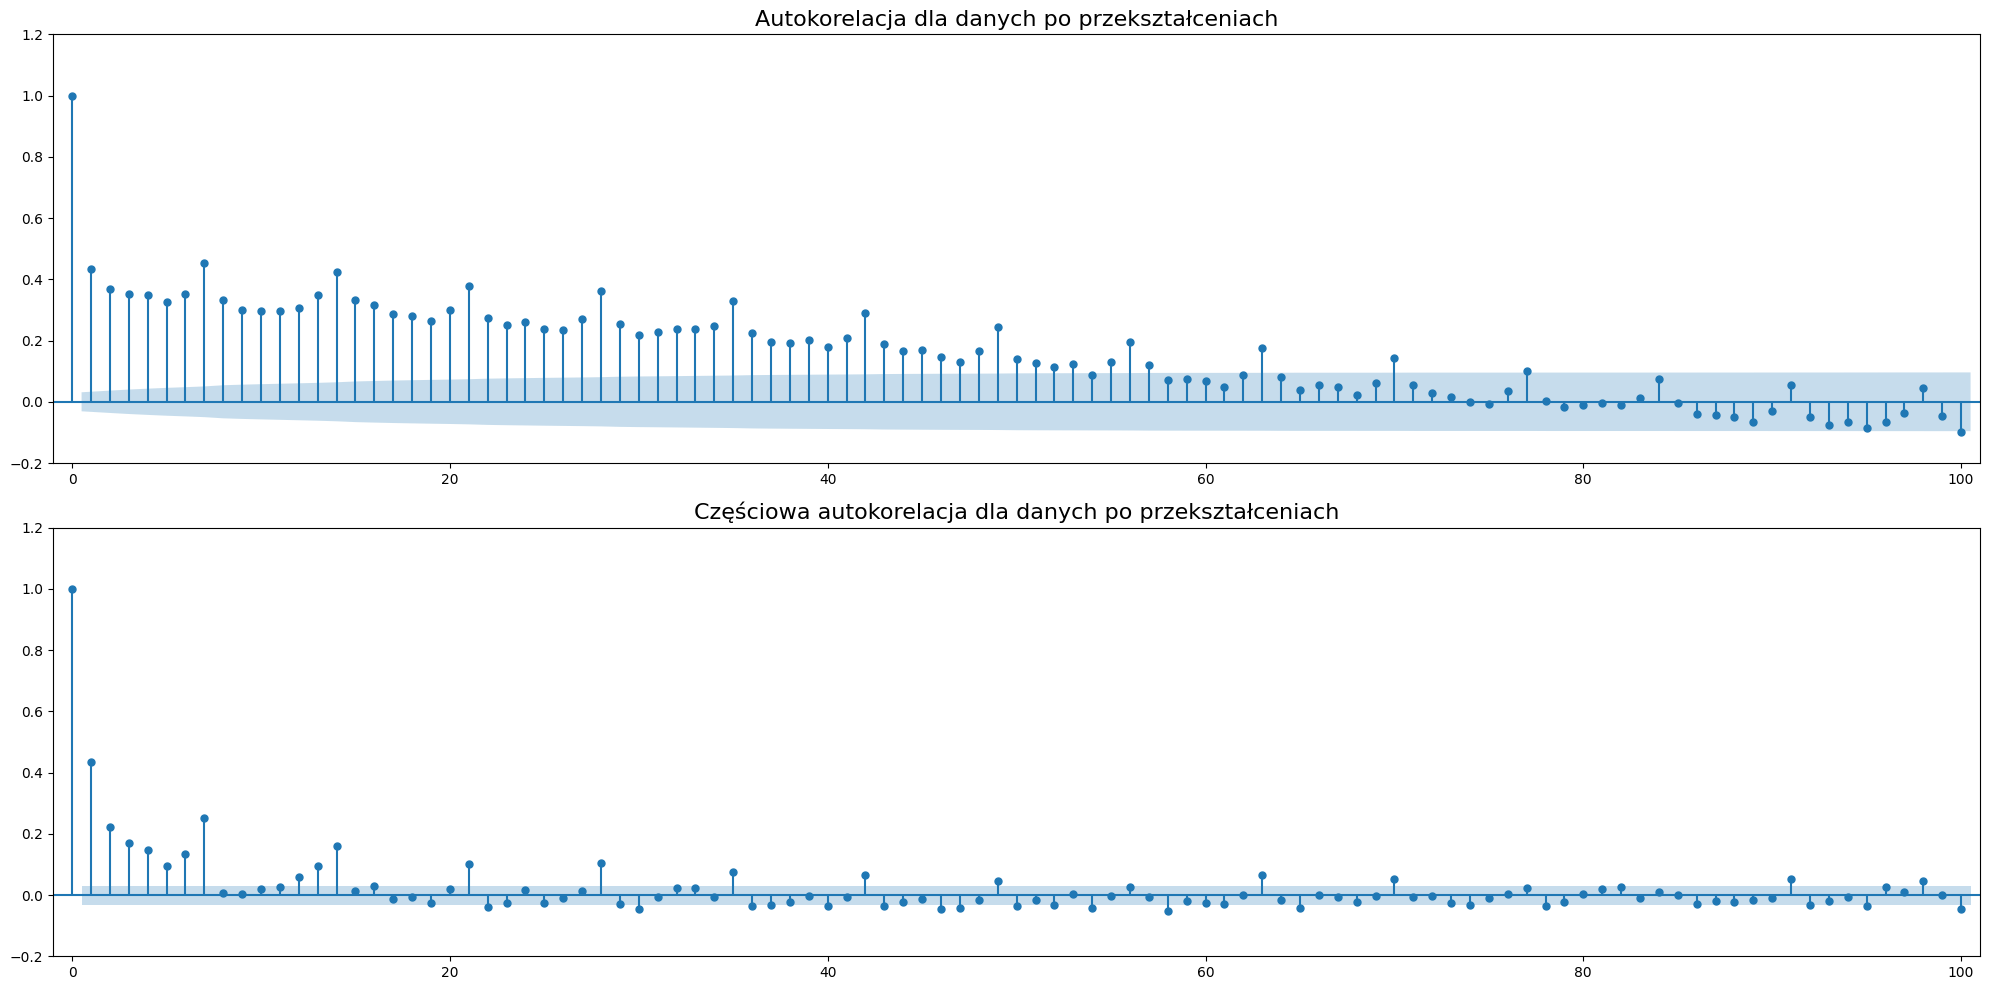

In [108]:
h = 100

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plot_acf(count_bez_sezonu, lags=min(h, len(count) - 1), adjusted=True, ax=plt.gca())
plt.title("Autokorelacja dla danych po przekształceniach", fontsize=16
          )
plt.xlim([-1, 101])
plt.ylim([-0.2, 1.2])
# Partial Autocorrelation Function
plt.subplot(2, 1, 2)
plot_pacf(count_bez_sezonu, lags=min(h, len(count) - 1), method='ywm', ax=plt.gca())
plt.title("Częściowa autokorelacja dla danych po przekształceniach", fontsize=16)
plt.xlim([-1, 101])
plt.ylim([-0.2, 1.2])

plt.tight_layout()
plt.show()


<Figure size 2000x1000 with 0 Axes>

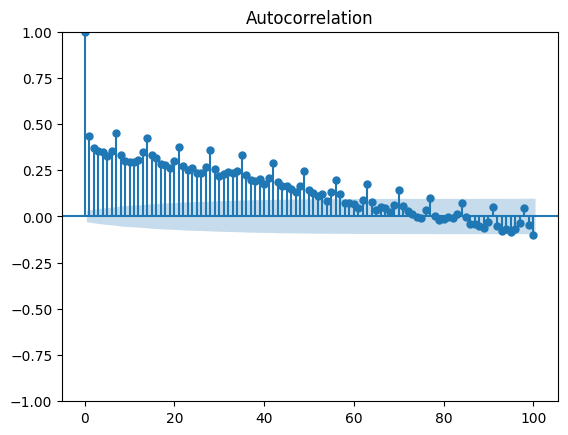

In [109]:
plt.figure(figsize = (20, 10))
h = 100
plot_acf(count_bez_sezonu, lags=h, adjusted=True)
plt.show()

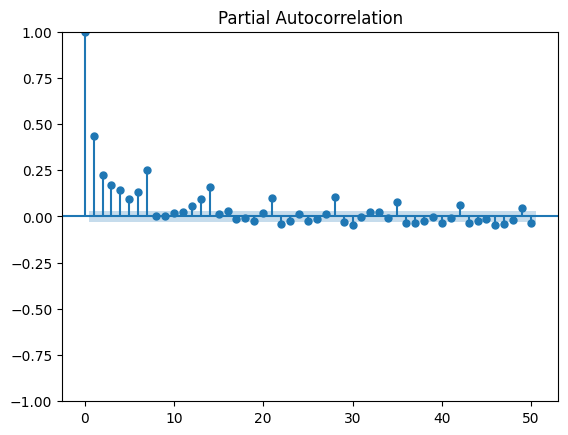

In [110]:
h = 50
plot_pacf(count_bez_sezonu, lags=h, method='ywm')
plt.show()

# MODELOWANIE DANYCH PRZY POMOCY ARMA

In [111]:
df = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 3
max_q = 3

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(count_bez_sezonu, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

In [112]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
5,1,2,17227.327545,17258.767703,17238.475670
7,2,1,17227.617630,17259.057787,17238.765755
8,2,2,17229.318705,17267.046895,17242.696455
4,1,1,17254.708808,17279.860934,17263.627308
6,2,0,17707.693412,17732.845538,17716.611912


Bierzemy ARMA(2,2)

In [113]:



# Dopasowanie modelu ARMA(2,2)
model = ARIMA(count_bez_sezonu, order=(2, 0,2))  # ARMA(p=2, d=0, q=2)
fitted_model = model.fit()

# Wyświetlenie współczynników modelu
print(fitted_model.summary())

# Pobranie parametrów
ar_params = fitted_model.arparams  # Współczynniki AR
ma_params = fitted_model.maparams  # Współczynniki MA
residua = fitted_model.resid
print(f"Współczynniki AR: {ar_params}")
print(f"Współczynniki MA: {ma_params}")
print(f"Residua: {residua}")


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3976
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -8608.659
Date:                Mon, 27 Jan 2025   AIC                          17229.319
Time:                        21:46:23   BIC                          17267.047
Sample:                             0   HQIC                         17242.696
                               - 3976                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0159      0.309     -0.051      0.959      -0.622       0.591
ar.L1          1.0010      0.190      5.272      0.000       0.629       1.373
ar.L2         -0.0142      0.187     -0.076      0.9

# Przedzialy ufności PACF i ACF

In [114]:
def ARMA_22_generator(n, sigma_2, phi_1, phi_2, theta_1, theta_2):
    Z_t = np.random.normal(0, sigma_2, n+2)

    X_t = [1 , 1]
    for t in range(n):
        X = phi_1*X_t[t+1] + phi_2*X_t[t] + Z_t[t +2] +  theta_1 *Z_t[ t+1] + theta_2*Z_t[t]
        X_t.append(X)

    return X_t[2:]

In [115]:
phi_1, phi_2 = ar_params
theta_1, theta_2 = ma_params
sigma_2 = 4.4718

n = len(count_bez_sezonu)
h = 50
N = 100
X_t_vector = [ARMA_22_generator(n, sigma_2, phi_1, phi_2, theta_1, theta_2) for _ in range(N)]

ACF

In [116]:
A_empiric_acf = []
for X_t in X_t_vector:
    empiric_autocorr = [autocorr(X_t, h_value) for h_value in range(h)]

    A_empiric_acf.append(empiric_autocorr)  


In [117]:
empiric_quantile_005_values = []
empiric_quantile_095_values = []

for i in range(len(A_empiric_acf[0])):
    A_empiric_column = [A_empiric_acf[j][i] for j in range(len(X_t_vector))]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values.append(quantile_empiric_005)
    empiric_quantile_095_values.append(quantile_empiric_095)




In [118]:
cout_acf = [autocorr(count_bez_sezonu, h_value) for h_value in range(h)]

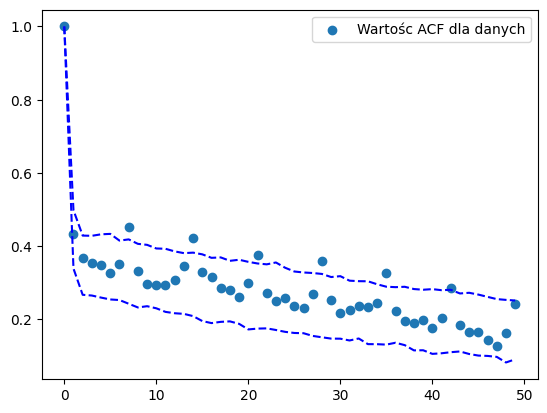

In [119]:
h_values = np.arange(0, h, 1)
plt.plot(h_values, empiric_quantile_005_values, linestyle = "--", color = "blue")
plt.plot(h_values, empiric_quantile_095_values, linestyle = "--", color = "blue")

plt.scatter(h_values, cout_acf, label= "Wartośc ACF dla danych")

plt.legend()
plt.show()


PACF

In [120]:
A_empiric_pacf = []
for X_t in X_t_vector:
    empiric_pacf = pacf(X_t, 50) 

    A_empiric_pacf.append(empiric_pacf)   

In [121]:
empiric_quantile_005_values_pacf = []
empiric_quantile_095_values_pacf = []

for i in range(len(A_empiric_pacf[0])):
    A_empiric_column = [A_empiric_pacf[j][i] for j in range(len(X_t_vector))]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values_pacf.append(quantile_empiric_005)
    empiric_quantile_095_values_pacf.append(quantile_empiric_095)

In [122]:
count_pacf = pacf(count_bez_sezonu, 50)

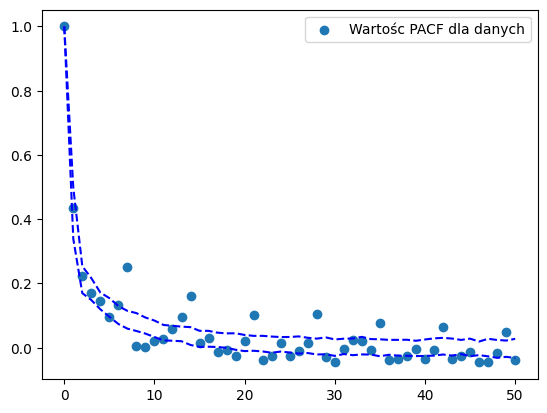

In [123]:
h_values = np.arange(0, 51, 1)
plt.plot(h_values, empiric_quantile_005_values_pacf, linestyle = "--", color = "blue")
plt.plot(h_values, empiric_quantile_095_values_pacf, linestyle = "--", color = "blue")

plt.scatter(h_values, count_pacf, label= "Wartośc PACF dla danych")

plt.legend()
plt.show()

# Linie kwantylowe z trajektorią

In [124]:
empiric_quantile_005_values_trajectory = []
empiric_quantile_095_values_trajectory = []

for i in range(len(X_t_vector[0])):
    A_empiric_column = [X_t_vector[j][i] for j in range(N)]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values_trajectory.append(quantile_empiric_005)
    empiric_quantile_095_values_trajectory.append(quantile_empiric_095)

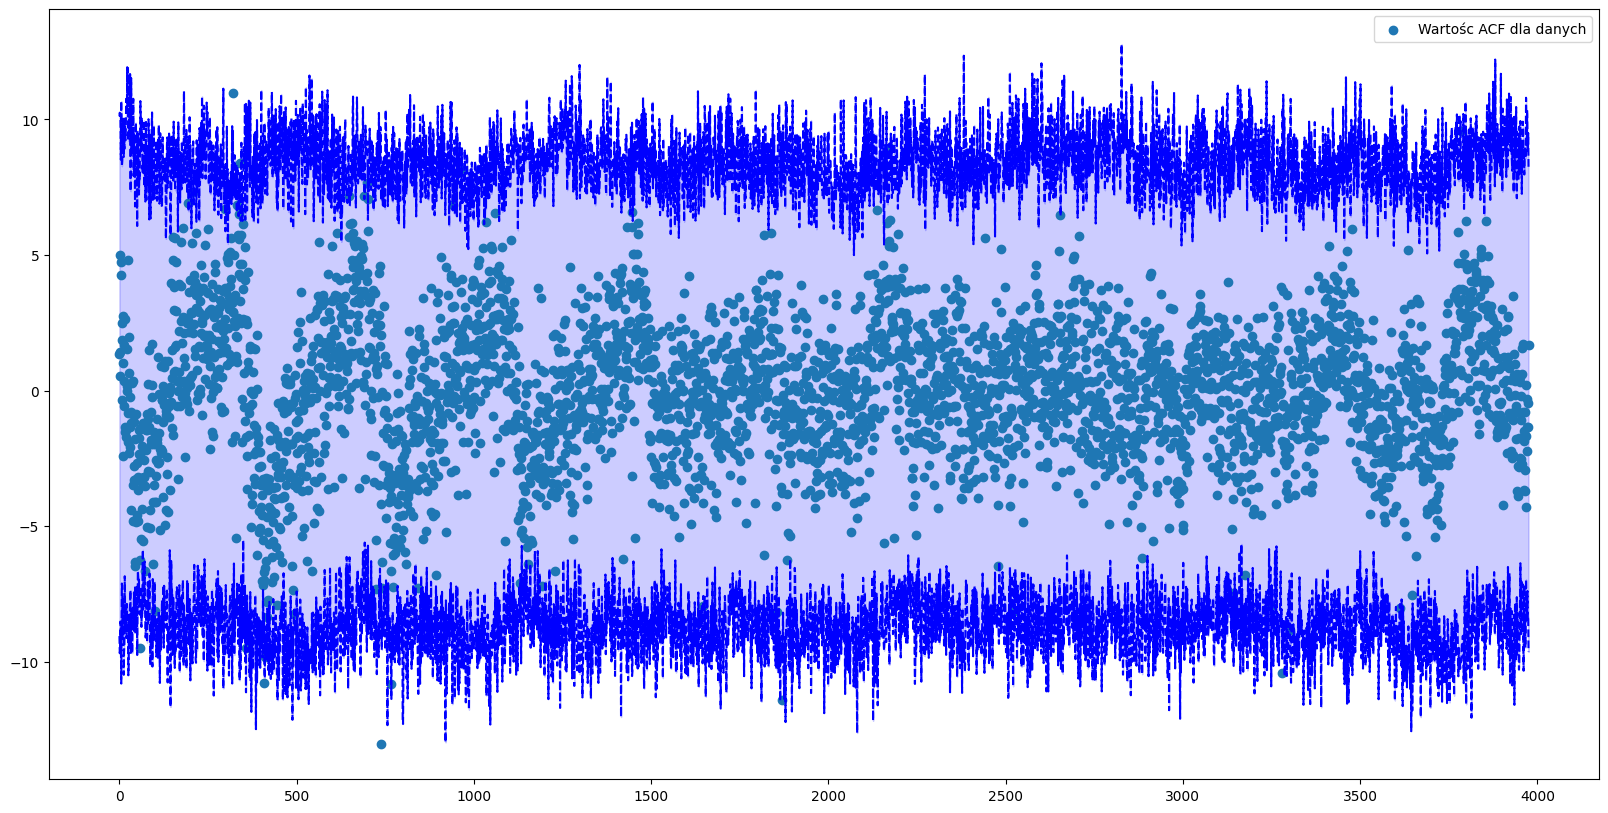

In [125]:
n_values = np.arange(0, len(count_99), 1)
plt.figure(figsize = (20, 10))
plt.plot(n_values, empiric_quantile_005_values_trajectory, linestyle = "--", color = "blue")
plt.plot(n_values, empiric_quantile_095_values_trajectory, linestyle = "--", color = "blue")

plt.fill_between(n_values, empiric_quantile_005_values_trajectory, empiric_quantile_095_values_trajectory, 
                 color="blue", alpha=0.2)

plt.scatter(n_values, count_bez_sezonu, label= "Wartośc ACF dla danych")

plt.legend()
plt.show()

# Linie kwantylowe z trajektorią (nałożony trend i sezonowość)

In [126]:
X_t_vector_z_dodatkami = X_t_vector + sezonowosc + prosta
print(len(X_t_vector), len(X_t_vector_z_dodatkami))

100 100


In [127]:
empiric_quantile_005_values_trajectory_z_dodatkami = []
empiric_quantile_095_values_trajectory_z_dodatkami = []

for i in range(len(X_t_vector_z_dodatkami[0])):
    A_empiric_column = [X_t_vector_z_dodatkami[j][i] for j in range(N)]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values_trajectory_z_dodatkami.append(quantile_empiric_005)
    empiric_quantile_095_values_trajectory_z_dodatkami.append(quantile_empiric_095)

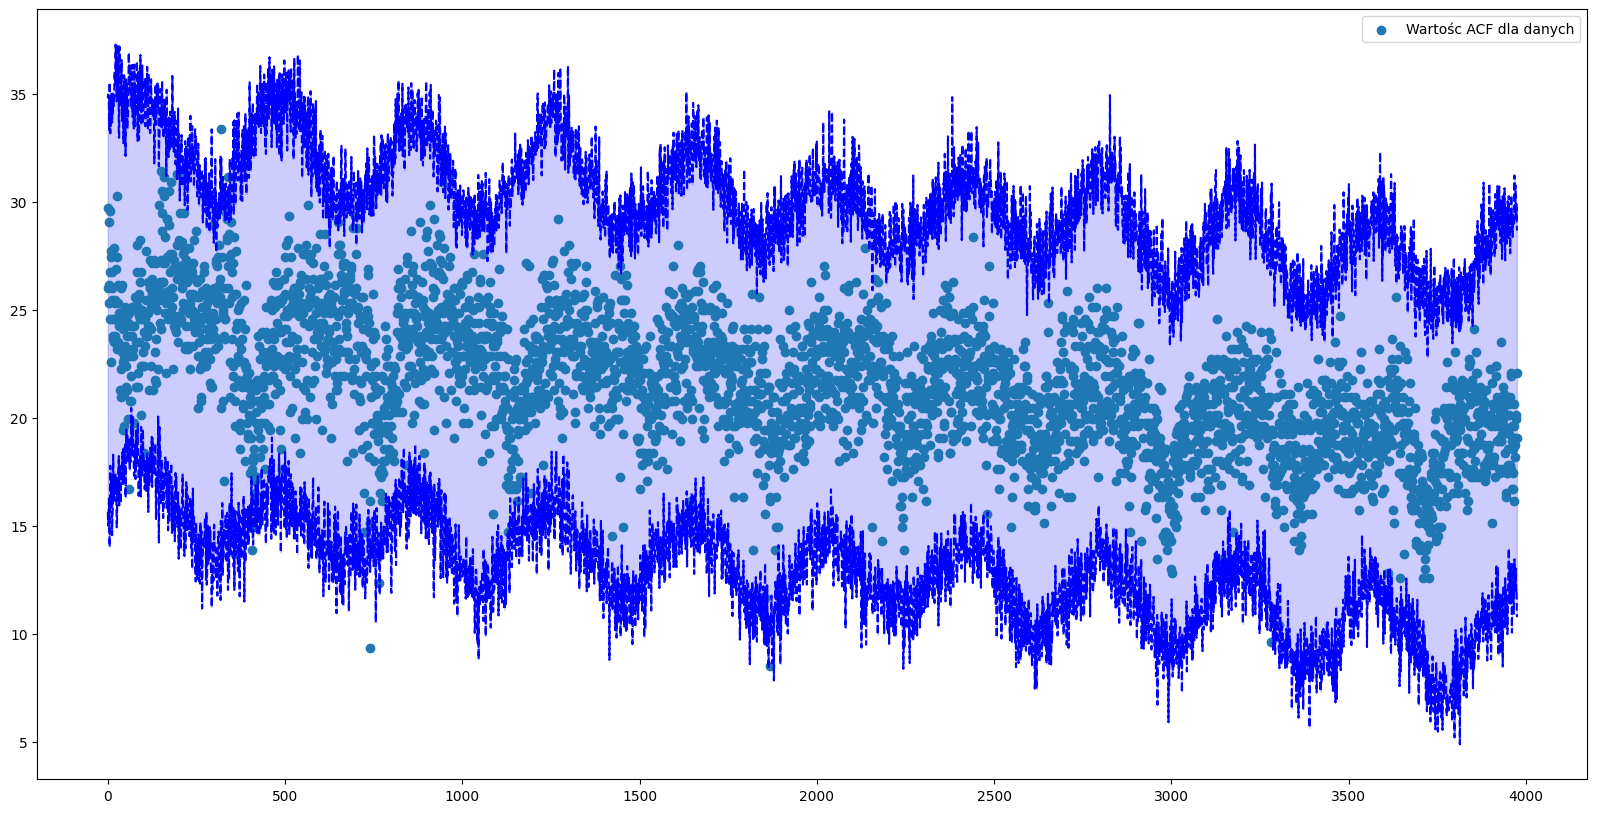

In [128]:
n_values = np.arange(0, len(count_99), 1)
plt.figure(figsize = (20, 10))
plt.plot(n_values, empiric_quantile_005_values_trajectory_z_dodatkami, linestyle = "--", color = "blue")
plt.plot(n_values, empiric_quantile_095_values_trajectory_z_dodatkami, linestyle = "--", color = "blue")

plt.fill_between(n_values, empiric_quantile_005_values_trajectory_z_dodatkami, empiric_quantile_095_values_trajectory_z_dodatkami, 
                 color="blue", alpha=0.2)

plt.scatter(n_values, count_transformed, label= "Wartośc ACF dla danych")

plt.legend()
plt.show()

# Predykcja danych

In [129]:
n = len(count)
X_t_vector = [ARMA_22_generator(n, sigma_2, phi_1, phi_2, theta_1, theta_2) for _ in range(N)]
sezonowosc_n = np.array([fun(x, params[0], params[1], params[2]) for x in np.arange(0, n, 1)])
prosta_n = b_0 + b_1*np.arange(0, n, 1)
X_t_vector_z_dodatkami = X_t_vector + sezonowosc_n + prosta_n

In [130]:
empiric_quantile_005_values_trajectory_z_dodatkami = []
empiric_quantile_095_values_trajectory_z_dodatkami = []

for i in range(len(X_t_vector_z_dodatkami[0])):
    A_empiric_column = [X_t_vector_z_dodatkami[j][i] for j in range(N)]

    quantile_empiric_005 = np.quantile(A_empiric_column, 0.05)
    quantile_empiric_095 = np.quantile(A_empiric_column, 0.95)
    
    empiric_quantile_005_values_trajectory_z_dodatkami.append(quantile_empiric_005)
    empiric_quantile_095_values_trajectory_z_dodatkami.append(quantile_empiric_095)

In [131]:
def inverse_box_cox(y_transformed, lamb):
    if lamb == 0:
        return np.exp(y_transformed)
    else:
        return (lamb * y_transformed + 1)**(1 / lamb)

quantile_005_inv_box_cox = inverse_box_cox(np.array(empiric_quantile_005_values_trajectory_z_dodatkami), lmbda_for_count)
quantile_095_inv_box_cox = inverse_box_cox(np.array(empiric_quantile_095_values_trajectory_z_dodatkami), lmbda_for_count)




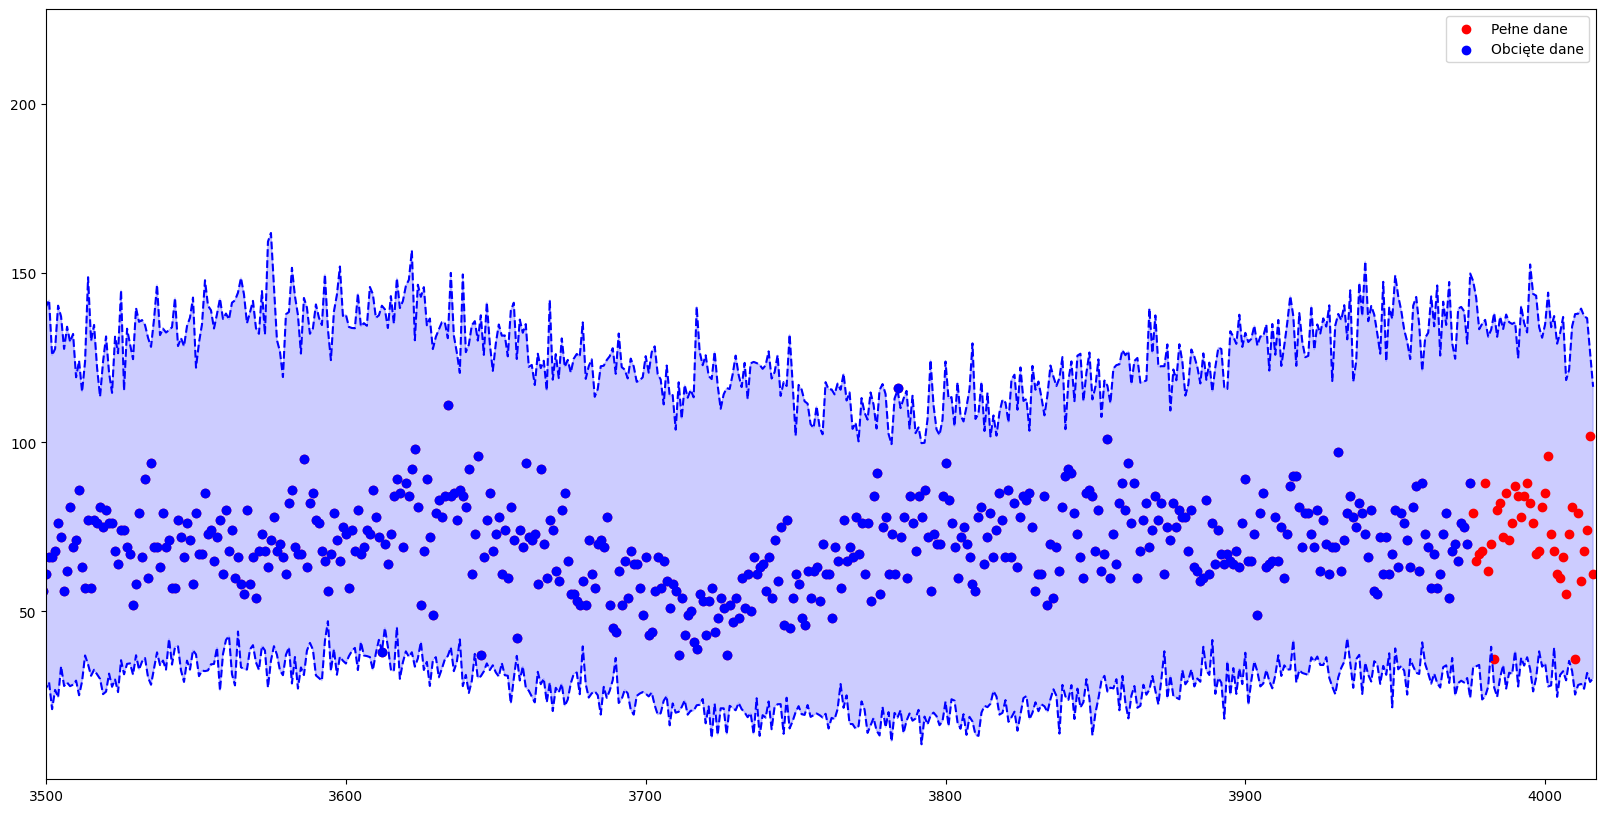

In [132]:
n_values = np.arange(0, n, 1)
plt.figure(figsize = (20, 10))
plt.plot(n_values, quantile_005_inv_box_cox, linestyle = "--", color = "blue")
plt.plot(n_values, quantile_095_inv_box_cox, linestyle = "--", color = "blue")

plt.fill_between(n_values, quantile_005_inv_box_cox, quantile_095_inv_box_cox, 
                 color="blue", alpha=0.2)

n_cut_values = np.arange(0, n_cut, 1)
plt.scatter(n_values, count, color = "red", label= "Pełne dane")
plt.scatter(n_cut_values, count_99, color = "blue", label= "Obcięte dane")
plt.legend()
plt.xlim([3500, 4017])
plt.show()

# RESIDUA

(0.0, 3976.0)

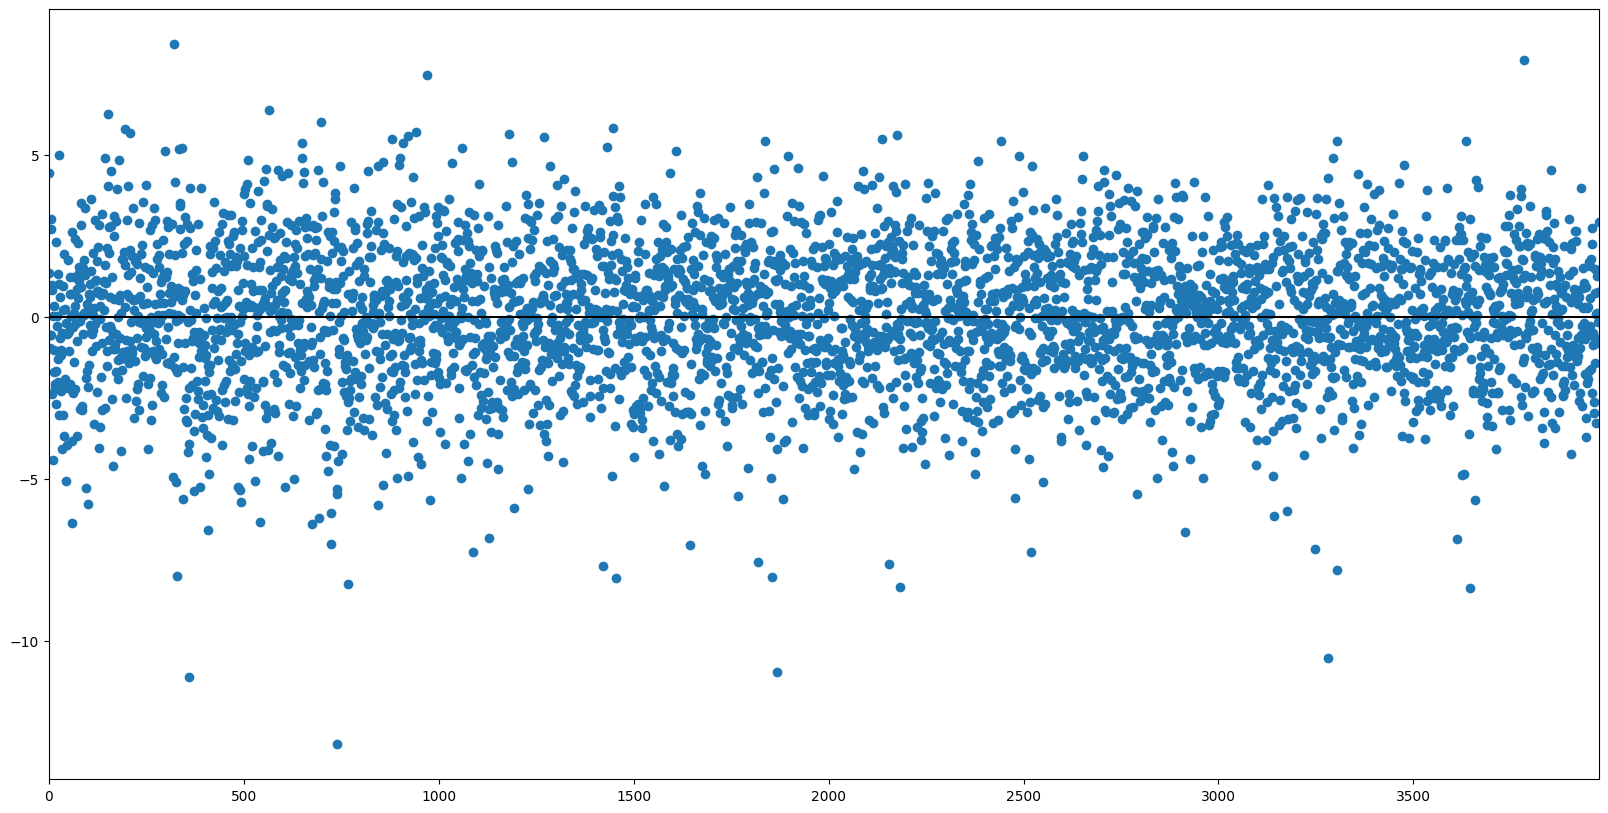

In [133]:
n_residua = len(residua)
plt.figure(figsize = (20, 10))
n_residua_values = np.arange(0, n_residua, 1)
plt.scatter(n_residua_values, residua)
plt.axhline(y = 0, c = "k")
plt.xlim([0, n_residua])

In [134]:
#Ttest
t_statistic, p_value = stats.ttest_1samp(residua, 0)

print("Statystyka t:", t_statistic)
print("Wartość p:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Odrzucamy hipotezę zerową - średnia residułów znacząco różni się od 0.")
else:
    print("Nie odrzucamy hipotezy zerowej - średnia residułów nie różni się znacząco od 0.")

Statystyka t: -0.17188814800577373
Wartość p: 0.8635342143605882
Nie odrzucamy hipotezy zerowej - średnia residułów nie różni się znacząco od 0.


In [135]:
#Levene’s Test

group1 = residua[:1000]
group2 = residua[2000:]



statistic, p_value = stats.levene(group1, group2, center='median')


print("Statystyka testu Levene'a:", statistic)
print("Wartość p:", p_value)

alpha = 0.1
if p_value < alpha:
    print("Odrzucamy hipotezę zerową - wariancje różnią się istotnie.")
else:
    print("Nie odrzucamy hipotezy zerowej - nie ma dowodów na różnice w wariancjach.")

Statystyka testu Levene'a: 30.69740176973777
Wartość p: 3.2790981690309514e-08
Odrzucamy hipotezę zerową - wariancje różnią się istotnie.


In [136]:
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(residua)


print("Statystyka testu ARCH:", arch_test[0])
print("Wartość p:", arch_test[1])
print("Liczba opóźnień:", arch_test[2])

alpha = 0.05
if arch_test[1] < alpha:
    print("Odrzucamy hipotezę zerową - występuje heteroskedastyczność warunkowa.")
else:
    print("Nie odrzucamy hipotezy zerowej - brak dowodów na heteroskedastyczność warunkową.")

Statystyka testu ARCH: 42.94858502696357
Wartość p: 5.079397568658703e-06
Liczba opóźnień: 4.329835013972349
Odrzucamy hipotezę zerową - występuje heteroskedastyczność warunkowa.


In [137]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox


ljung_box_test = acorr_ljungbox(residua, lags=10)


ljung_box_df = pd.DataFrame({
    'Statystyka Ljunga-Boxa': ljung_box_test['lb_stat'],
    'Wartość p': ljung_box_test['lb_pvalue']
})

print("Wyniki testu Ljunga-Boxa:")
print(ljung_box_df)


alpha = 0.05
if ljung_box_test['lb_pvalue'].iloc[-1] < alpha:
    print("\nOdrzucamy hipotezę zerową - residuale są autokorelacyjne.")
else:
    print("\nNie odrzucamy hipotezy zerowej - residuale nie są autokorelacyjne.")

Wyniki testu Ljunga-Boxa:
    Statystyka Ljunga-Boxa     Wartość p
1                 0.000108  9.917192e-01
2                 0.008602  9.957083e-01
3                 1.391864  7.074429e-01
4                 1.855530  7.623087e-01
5                10.443035  6.361225e-02
6                10.921895  9.082056e-02
7               131.969595  2.436203e-25
8               134.713427  2.977314e-25
9               146.972383  3.735256e-27
10              157.334676  1.149573e-28

Odrzucamy hipotezę zerową - residuale są autokorelacyjne.


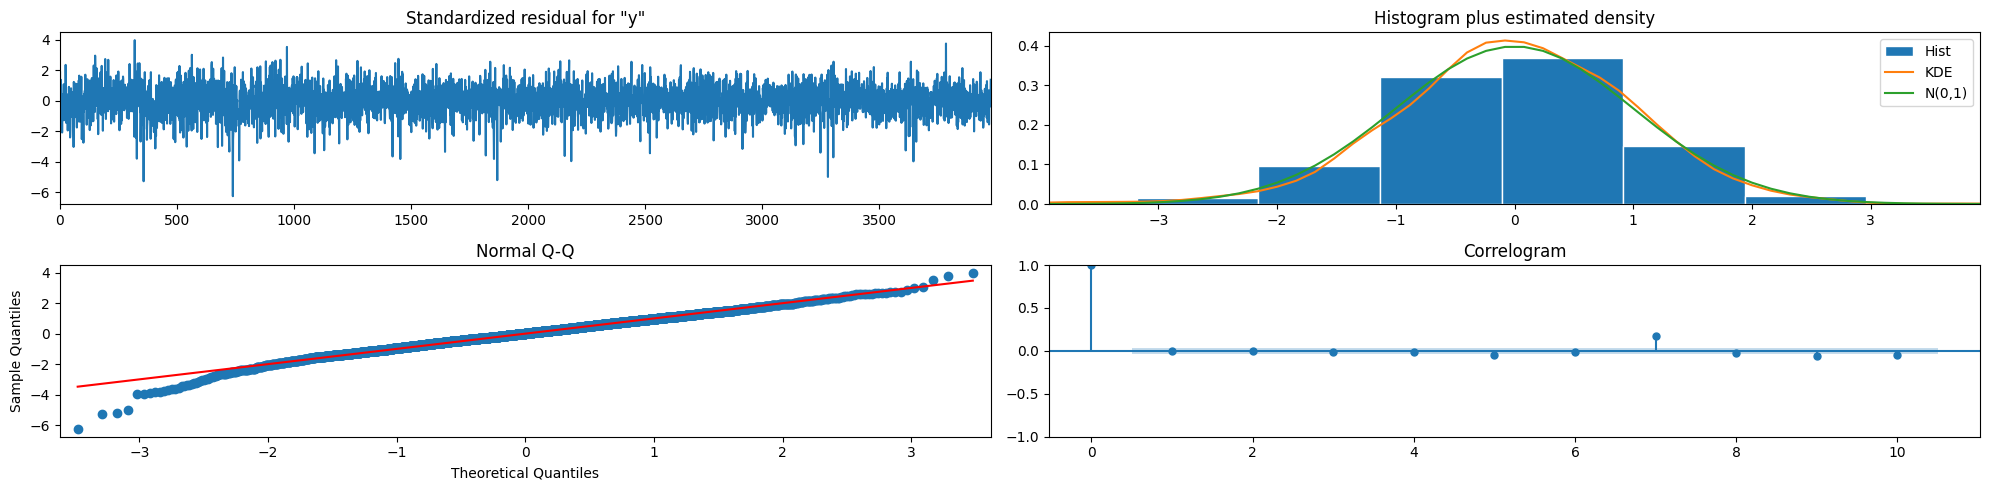

In [141]:
fitted_model.plot_diagnostics(0,figsize=(20,5))
plt.plot();
plt.tight_layout()

NameError: name 'sm' is not defined

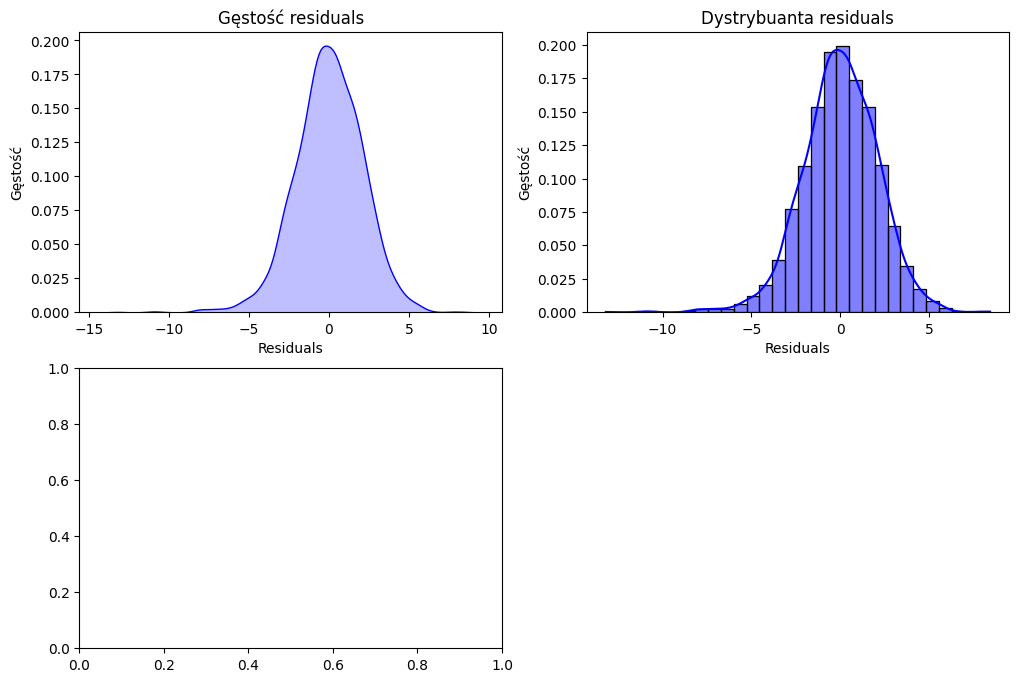

In [138]:

plt.figure(figsize=(12, 8))

# 1. Gęstość
plt.subplot(2, 2, 1)
sns.kdeplot(residua, color='b', fill=True)
plt.title('Gęstość residuals')
plt.xlabel('Residuals')
plt.ylabel('Gęstość')

# 2. Dystrybuanta
plt.subplot(2, 2, 2)
sns.histplot(residua, bins=30, stat='density', kde=True, color='b', edgecolor='black', fill=True)
plt.title('Dystrybuanta residuals')
plt.xlabel('Residuals')
plt.ylabel('Gęstość')

# 3. Wykres kwantylowy
plt.subplot(2, 2, 3)
sm.qqplot(residua, line='s', ax=plt.gca())
plt.title('Wykres kwantylowy residuals')

# 4. Testowanie na normalność
plt.subplot(2, 2, 4)
stat, p_value = normal_ad(residua)
plt.hist(residua, bins=30, color='b', alpha=0.6, edgecolor='black')
plt.axvline(np.mean(residua), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(residua) + 1.96 * np.std(residua), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(residua) - 1.96 * np.std(residua), color='orange', linestyle='dashed', linewidth=1)
plt.title(f'Test normalności (AD): Statystyka={stat:.3f}, p={p_value:.3f}')
plt.xlabel('Residuals')
plt.ylabel('Częstość')

plt.tight_layout()
plt.show()

# Interpretacja wyników testu
alpha = 0.05
if p_value < alpha:
    print("Odrzucamy hipotezę zerową - residuals nie są normalnie rozłożone.")
else:
    print("Nie odrzucamy hipotezy zerowej - residuals są normalnie rozłożone.")

# PACF i ACF residułów

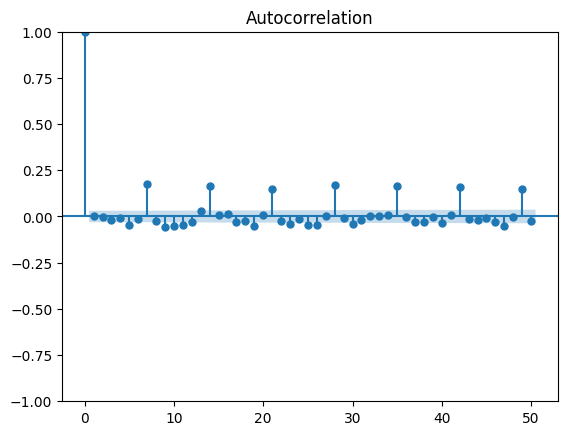

In [142]:
h = 50
plot_acf(residua, lags=h, adjusted=True)
plt.show()

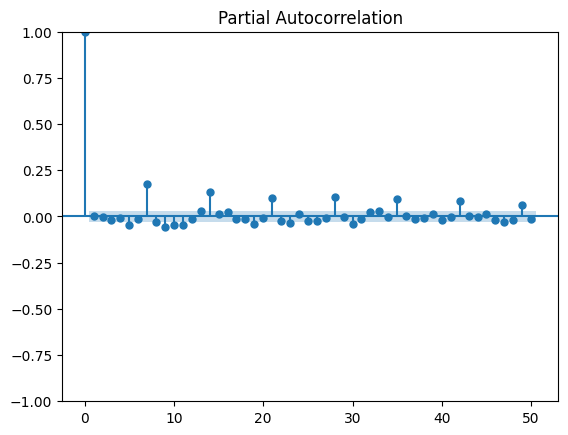

In [143]:
plot_pacf(residua, lags=h, method='ywm')
plt.show()